In [52]:
import os
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import constants as k
import utils
from calculate_instantaneous_firing_rate import calculate_firing_rates

In [53]:
data_dir = '/Users/rebekahzhang/data/neural_data'
pickle_dir = Path(os.path.join(data_dir, 'session_pickles'))
figure_dir = os.path.join(data_dir, 'figures')

In [54]:
units_vetted = pd.read_csv(os.path.join(data_dir, 'units_vetted.csv'), index_col=0).sort_values('unit_id')
sessions_vetted = pd.read_csv(os.path.join(data_dir, 'sessions_vetted.csv'), index_col=0).sort_values('num_units')

In [55]:
def get_data_for_debugging(units_vetted=units_vetted, session_id='RZ034_2024-07-13_str', unit_id=15):
    units_by_session = units_vetted.groupby("session_id")
    test_session = units_by_session.get_group(session_id)
    # session_id = test_session.loc[test_session['id'] == unit_id, "session_id"]
    session_fr = test_session.loc[test_session['id'] == unit_id, "session_fr"].iloc[0]
    events, trials, units = utils.get_session_data(session_id, pickle_dir)
    spikes = units[unit_id]
    return events, trials, spikes, session_fr
events, trials, spikes, session_fr = get_data_for_debugging(session_id="RZ036_2024-07-12_str", unit_id=0)

In [57]:
def prepare_data_for_histogram_by_quantile(trials, spikes, anchor, anchored_periods, sorter):
    trials = trials[trials.missed == False].copy()
    trials['aligned_start_time'] = trials["cue_off_time"] - trials["decision_time"]
    trials['aligned_end_time'] = trials['trial_length'] - trials["decision_time"]
    trials['quantile'] = pd.qcut(trials[sorter], q=10, labels=list(range(1,11)))
    
    # spikes_clipped = spikes.loc[spikes[anchor]>-3].copy()
    relevant_periods = anchored_periods[anchor]
    relevant_spikes = spikes.loc[spikes.period.isin(relevant_periods)].copy()

    common_trial_ids = pd.merge(trials[['trial_id']], relevant_spikes[['trial_id']], 
                                on='trial_id')['trial_id'].unique().tolist()
    
    trials_histo = trials.loc[trials.trial_id.isin(common_trial_ids)]
    spikes_histo = relevant_spikes.loc[spikes.trial_id.isin(common_trial_ids)]

    return trials_histo, spikes_histo

In [58]:
# def generate_unit_decision_data_dict(trials_histo, spikes_histo, anchor, time_step, trial_count_mask, sigma, session_fr):
#     bin_centers, mean_fr, sem_fr = calculate_firing_rates(
#             trials_histo, spikes_histo, anchor, time_step, trial_count_mask, sigma, session_fr
#         )
#     decision_data_dict = {
#         "trial_mean_fr": mean_fr.mean(),
#         "trial_sem_fr": sem_fr.mean(),
#         "trial_peak_fr": mean_fr.max(),
#         "trial_peak_fr_time": bin_centers[np.argmax(mean_fr)],
#         "trial_min_fr": mean_fr.min(),
#         "trial_min_fr_time": bin_centers[np.argmin(mean_fr)],
#         }

#     for quantile in trials_histo['quantile'].dropna().unique():
#         trials_quantile = trials_histo.loc[trials_histo['quantile'] == quantile]
#         spikes_quantile = spikes_histo.loc[spikes_histo.trial_id.isin(trials_quantile.trial_id)]
#         bin_centers_q, mean_fr_q, sem_fr_q = calculate_firing_rates(
#                 trials_quantile, spikes_quantile, anchor, time_step, trial_count_mask, sigma
#                 )
#         decision_data_dict[f"{quantile}_mean_fr"] = mean_fr_q.mean()
#         decision_data_dict[f"{quantile}_sem_fr"] = sem_fr_q.mean()
#         decision_data_dict[f"{quantile}_peak_fr"] = mean_fr_q.max()
#         decision_data_dict[f"{quantile}_peak_fr_time"] = bin_centers_q[np.argmax(mean_fr_q)]
#         decision_data_dict[f"{quantile}_min_fr"] = mean_fr_q.min()
#         decision_data_dict[f"{quantile}_min_fr_time"] = bin_centers_q[np.argmin(mean_fr_q)]
#     return decision_data_dict

In [77]:
def generate_unit_decision_data_dict(trials_histo, spikes_histo, anchor, time_step, trial_count_mask, sigma, session_fr):
    # Calculate firing rates for all trials
    bin_centers, mean_fr, sem_fr = calculate_firing_rates(
        trials_histo, spikes_histo, anchor, time_step, trial_count_mask, sigma, session_fr
    )
    
    # Find indices within the time window of interest (-0.5s to 0s)
    time_window_mask = (bin_centers >= -0.5) & (bin_centers <= 0)
    bin_centers_window = bin_centers[time_window_mask]
    mean_fr_window = mean_fr[time_window_mask]
    
    # Calculate metrics for the window
    if len(mean_fr_window) > 0:  # Only calculate if there are points in the window
        window_peak_fr = mean_fr_window.max()
        window_peak_fr_time = bin_centers_window[np.argmax(mean_fr_window)]
    else:
        window_peak_fr = np.nan
        window_peak_fr_time = np.nan
    
    decision_data_dict = {
        "trial_mean_fr": mean_fr.mean(),
        "trial_sem_fr": sem_fr.mean(),
        "trial_peak_fr": mean_fr.max(),
        "trial_peak_fr_time": bin_centers[np.argmax(mean_fr)],
        "trial_min_fr": mean_fr.min(),
        "trial_min_fr_time": bin_centers[np.argmin(mean_fr)],
        "window_peak_fr": window_peak_fr,  # Peak in -0.5 to 0s window
        "window_peak_fr_time": window_peak_fr_time,  # Time of peak in window
    }

    return decision_data_dict


In [78]:
anchor = k.TO_DECISION
sorter = k.WAIT_LENGTH

time_step = 0.1
trial_count_mask = 5
sigma = 2

trials_histo, spikes_histo = prepare_data_for_histogram_by_quantile(trials, spikes, anchor, k.ANCHORED_PERIODS, sorter)
fr_dict = generate_unit_decision_data_dict(trials_histo, spikes_histo, anchor, time_step, trial_count_mask, sigma, session_fr)

In [79]:
units_by_session = units_vetted.groupby("session_id")
unit_data_list = []
for session_id, session_units in units_by_session:
    events, trials, units = utils.get_session_data(session_id, pickle_dir)
    for _, unit_info in session_units.iterrows():
        unit_id = unit_info['unit_id']
        session_fr = unit_info['session_fr']
        spikes = units[unit_info['id']]
        trials_histo, spikes_histo = prepare_data_for_histogram_by_quantile(
            trials, spikes, anchor, k.ANCHORED_PERIODS, sorter
            )
        unit_decision_data_dict = generate_unit_decision_data_dict(
            trials_histo, spikes_histo, anchor, time_step, trial_count_mask, sigma, session_fr
            )
        unit_data = {'unit_id': unit_id} | unit_decision_data_dict
        unit_data_list.append(unit_data)
unit_decision_data_df = pd.DataFrame(unit_data_list)

In [80]:
unit_decision_data_df.to_csv(os.path.join(data_dir, 'unit_decision_data_df.csv'))

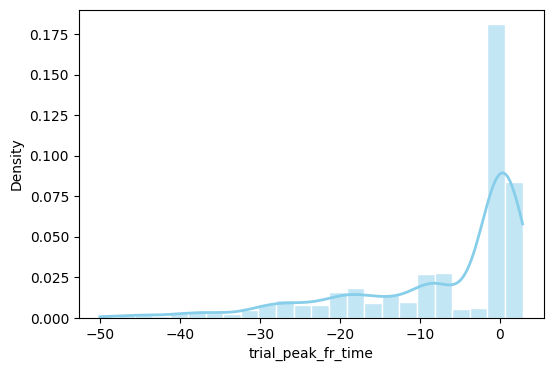

In [81]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(
    data=unit_decision_data_df['trial_peak_fr_time'],
    kde=True,          # Adds KDE trend line
    stat="density",    # Normalizes histogram to match KDE scale
    bins="auto",       # Auto-selects bin size (or set manually, e.g., bins=30)
    color="skyblue",   # Histogram color
    edgecolor="white", # Edge color for bars
    line_kws={"color": "red", "lw": 2}  # KDE line style
)

In [82]:
decision_units = unit_decision_data_df[unit_decision_data_df['trial_peak_fr_time'].between(-0.5, 0)]

In [83]:
decision_units_vetted = pd.merge(
    units_vetted, decision_units,
    how = "inner"
)

In [84]:
decision_units_by_region = decision_units_vetted.groupby("region")
for region, region_data in decision_units_by_region:
    source_folder = os.path.join(figure_dir, 'raster_histo_to_decision_by_wait_length', region)
    destination_folder = os.path.join(figure_dir, 'interesting_ones', region)
    
    # Create destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)
    
    print(f"Processing region: {region}")
    print(f"Destination folder: {destination_folder}")
    
    for _, unit_data in region_data.iterrows():
        unit_id = unit_data['unit_id']
        session_id = unit_data['unit_id']  # Make sure this column exists
        
        source_path = os.path.join(source_folder, f"{session_id}.png")
        destination_path = os.path.join(destination_folder, f"{session_id}.png")
        
        try:
            shutil.copy2(source_path, destination_path)  # copy2 preserves metadata
        except FileNotFoundError:
            print(f"Warning: Source file not found - {source_path}")
        except Exception as e:
            print(f"Error copying {source_path}: {str(e)}")

Processing region: str
Destination folder: /Users/rebekahzhang/data/neural_data/figures/interesting_ones/str
Processing region: v1
Destination folder: /Users/rebekahzhang/data/neural_data/figures/interesting_ones/v1


In [85]:
decision_units_vetted.to_csv(os.path.join(data_dir, 'decision_units_df.csv'))

step 2 below

In [86]:
decision_units_vetted = pd.read_csv(os.path.join(data_dir, 'decision_units_df.csv'), index_col=0)

In [87]:
decision_units_vetted

,session_id,id,unit_id,region,percent_trials_w_spikes,session_fr,trial_mean_fr,trial_sem_fr,trial_peak_fr,trial_peak_fr_time,trial_min_fr,trial_min_fr_time,window_peak_fr,window_peak_fr_time
0,RZ034_2024-07-13_str,11,RZ034_2024-07-13_str-unit_11,str,1.000000,8.931847,0.906204,0.078383,1.405784,-0.15,0.682273,-7.65,1.405784,-0.15
1,RZ034_2024-07-13_str,15,RZ034_2024-07-13_str-unit_15,str,0.996951,10.375676,0.637126,0.050049,3.583779,-0.15,0.011354,-8.15,3.583779,-0.15
2,RZ034_2024-07-13_str,16,RZ034_2024-07-13_str-unit_16,str,1.000000,5.300995,0.709753,0.090804,3.000730,-0.25,0.190509,-8.15,3.000730,-0.25
3,RZ034_2024-07-13_str,17,RZ034_2024-07-13_str-unit_17,str,0.996951,6.078158,0.734163,0.073077,3.668656,-0.25,0.077568,-8.55,3.668656,-0.25
4,RZ034_2024-07-13_str,20,RZ034_2024-07-13_str-unit_20,str,1.000000,6.635554,0.849842,0.072534,1.909180,-0.35,0.427126,3.05,1.909180,-0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,RZ065_2025-02-20_str,9,RZ065_2025-02-20_str-unit_9,str,0.990783,10.357649,0.985878,0.094767,2.448680,-0.25,0.501300,3.05,2.448680,-0.25
240,RZ065_2025-02-21_v1,1,RZ065_2025-02-21_v1-unit_1,v1,1.000000,6.454969,1.106894,0.089630,3.270989,-0.25,0.416601,3.05,3.270989,-0.25
241,RZ065_2025-02-21_v1,12,RZ065_2025-02-21_v1-unit_12,v1,1.000000,4.087781,0.754174,0.074025,2.716677,-0.05,0.250795,-7.95,2.716677,-0.05
242,RZ065_2025-02-21_v1,21,RZ065_2025-02-21_v1-unit_21,v1,0.996689,2.948668,0.973299,0.124938,1.606050,-0.05,0.255076,-9.25,1.606050,-0.05


In [147]:
def plot_regression(quantile_dict, unit_id, regression_folder):
    plt.figure(figsize=(10, 7))
    # ax = sns.regplot(x=quantile_dict['x'], y=quantile_dict['y'], 
    #                 scatter_kws={'s': 80, 'alpha': 0.7, 'edgecolor': 'w', 'color': 'blue'},
    #                 line_kws={'color': 'blue', 'lw': 2, 'alpha': 0.7})  # Changed to blue
    ax = sns.regplot(x=quantile_dict['x'], y=quantile_dict['y'])

    stats_text = (
        f"y = {quantile_dict['slope']:.3f}x + {quantile_dict['intercept']:.3f}\n"
        f"R² = {quantile_dict['r_squared']:.3f}\n"
        f"p-value = {quantile_dict['p_value']:.4f}\n"
    )

    # Add text box with statistics
    plt.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round'),
            fontsize=10,
            family='monospace')

    # Add labels and title
    plt.xlabel("X values", fontsize=12)
    plt.ylabel("Y values", fontsize=12)
    plt.title(unit_id)

    plt.savefig(os.path.join(regression_folder, f"{unit_id}_quantile_regression.png"), dpi=300)
    plt.clf()
    plt.close()

In [148]:
def generate_10_quantile_linear_regression_data(trials_histo, spikes_histo, anchor, time_step, trial_count_mask, sigma, unit_id):
    # Calculate for each quantile
    x = []
    y = []
    for quantile in trials_histo['quantile'].dropna().unique():
        trials_quantile = trials_histo.loc[trials_histo['quantile'] == quantile]
        spikes_quantile = spikes_histo.loc[spikes_histo.trial_id.isin(trials_quantile.trial_id)]
        bin_centers_q, mean_fr_q, sem_fr_q = calculate_firing_rates(
            trials_quantile, spikes_quantile, anchor, time_step, trial_count_mask, sigma
        )
        
        # Find indices within the time window for this quantile
        time_window_mask_q = (bin_centers_q >= -0.5) & (bin_centers_q <= 0)
        mean_fr_q_window = mean_fr_q[time_window_mask_q]
        
        # Calculate window metrics for quantile
        if len(mean_fr_q_window) > 0:
            q_window_peak_fr = mean_fr_q_window.max()
        else:
            q_window_peak_fr = np.nan
        
        x.append(trials_quantile['wait_length'].mean())
        y.append(q_window_peak_fr)

    # Convert to numpy arrays and add constant term
    x = np.array(x)
    y = np.array(y)

    # Filter out any NaN values that might be present
    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    # Only perform regression if we have at least 2 valid points
    if len(x_valid) >= 2:
        # Add constant term for intercept
        X = sm.add_constant(x_valid)
        model = sm.OLS(y_valid, X).fit()
        
        # Extract parameters correctly
        slope = model.params[1]  # Note: [1] is the slope
        intercept = model.params[0]  # [0] is the intercept
        r_squared = model.rsquared
        p_value = model.pvalues[1]  # p-value for the slope
        
        quantile_data_dict = {
            "x": x_valid,
            "y": y_valid,
            "slope": slope,
            "intercept": intercept,
            "r_squared": r_squared,
            "p_value": p_value,
            "n_quantiles": len(x_valid),
            "significant": p_value < 0.05  # Added significance flag
        }
    else:
        # Return NaN values if not enough data points
        quantile_data_dict = {
            "x": x_valid,
            "y": y_valid,
            "slope": np.nan,
            "intercept": np.nan,
            "r_squared": np.nan,
            "p_value": np.nan,
            "n_quantiles": len(x_valid),
            "significant": False
        }
    plot_regression(quantile_data_dict, unit_id, os.path.join(figure_dir, 'regression'))
    return quantile_data_dict

In [152]:
anchor = k.TO_DECISION
sorter = k.WAIT_LENGTH

time_step = 0.1
trial_count_mask = 5
sigma = 2

unit_id = 'RZ034_2024-07-13_str-unit_15'

trials_histo, spikes_histo = prepare_data_for_histogram_by_quantile(trials, spikes, anchor, k.ANCHORED_PERIODS, sorter)
quantile_dict = generate_10_quantile_linear_regression_data(trials_histo, spikes_histo, anchor, time_step, trial_count_mask, sigma, unit_id)

In [154]:
decision_units_by_session = decision_units_vetted.groupby("session_id")
unit_ten_quantile_data_list = []
for session_id, session_units in decision_units_by_session:
    events, trials, units = utils.get_session_data(session_id, pickle_dir)
    for _, unit_info in session_units.iterrows():
        unit_id = unit_info['unit_id']
        spikes = units[unit_info['id']]
        trials_histo, spikes_histo = prepare_data_for_histogram_by_quantile(
            trials, spikes, anchor, k.ANCHORED_PERIODS, sorter
            )
        unit_ten_quantile_data_dict = generate_10_quantile_linear_regression_data(
            trials_histo, spikes_histo, anchor, time_step, trial_count_mask, sigma, unit_id
            )
        unit_ten_quantile_data = {'unit_id': unit_id} | unit_ten_quantile_data_dict
        unit_ten_quantile_data_list.append(unit_ten_quantile_data)
unit_ten_quantile_data_df = pd.DataFrame(unit_ten_quantile_data_list)

In [155]:
unit_ten_quantile_data_df.to_csv(os.path.join(data_dir, 'unit_ten_quantile_data_df.csv'))

In [156]:
significant_decision_units = unit_ten_quantile_data_df[unit_ten_quantile_data_df['significant'] == True]

In [157]:
significant_decision_units

,unit_id,x,y,slope,intercept,r_squared,p_value,n_quantiles,significant
0,RZ034_2024-07-13_str-unit_11,"[1.342521277841193, 1.853291707919225, 0.63520...","[12.520822702415579, 12.583828072988815, 10.89...",0.590606,10.684883,0.591538,0.009308,10,True
1,RZ034_2024-07-13_str-unit_15,"[1.342521277841193, 1.853291707919225, 0.62324...","[30.656254669013055, 37.52243858238295, 25.599...",2.714017,28.112754,0.729119,0.001665,10,True
2,RZ034_2024-07-13_str-unit_16,"[1.342521277841193, 1.853291707919225, 0.63520...","[13.607685712853911, 14.975971675482434, 15.15...",0.592835,14.029598,0.416085,0.044021,10,True
3,RZ034_2024-07-13_str-unit_17,"[1.345061316588236, 1.853291707919225, 0.63520...","[18.670102927107656, 19.891252680018397, 16.51...",1.575781,17.106066,0.872090,0.000077,10,True
4,RZ034_2024-07-13_str-unit_20,"[1.342521277841193, 1.853291707919225, 0.63520...","[10.641214004062409, 12.02699028562591, 10.340...",0.430653,11.338905,0.477453,0.026922,10,True
...,...,...,...,...,...,...,...,...,...
232,RZ063_2025-03-06_v1-unit_6,"[2.2676289829250784, 0.37266059464920187, 3.62...","[12.373150262313384, 32.43787770125138, 18.002...",-3.098604,23.421010,0.505904,0.021086,10,True
237,RZ065_2025-02-20_str-unit_5,"[1.9558546665748677, 0.9008801081006026, 4.500...","[9.252406501712688, 12.59796650158508, 7.26864...",-0.613899,10.284740,0.629715,0.006144,10,True
239,RZ065_2025-02-20_str-unit_9,"[1.9558546665748677, 0.9899715848263403, 3.679...","[17.73402188071359, 14.13152423451709, 28.9694...",1.033729,19.641975,0.519779,0.018635,10,True
240,RZ065_2025-02-21_v1-unit_1,"[1.0658949695254085, 1.5637776955644942, 0.468...","[18.82104985857196, 19.594746428349346, 18.481...",0.650335,19.136740,0.659794,0.004302,10,True


In [158]:
significant_decision_units.to_csv(os.path.join(data_dir, 'significant_decision_units.csv'))

In [166]:
ranked = significant_decision_units.copy().sort_values('p_value', ascending=True)

In [167]:
ranked

,unit_id,x,y,slope,intercept,r_squared,p_value,n_quantiles,significant
54,RZ037_2024-07-16_str-unit_5,"[2.367839511890836, 4.3659609924599785, 1.3151...","[48.6656862534527, 45.07601825892488, 50.62381...",-1.284553,50.921864,0.907956,0.000020,10,True
67,RZ037_2024-07-17_str-unit_45,"[2.570822398182421, 1.196961652227739, 0.33821...","[33.93563813354753, 36.6352756155499, 37.95622...",-0.975880,38.656831,0.891956,0.000039,10,True
100,RZ047_2024-11-21_v1-unit_0,"[0.2158423358814279, 2.7394794396323867, 1.182...","[9.950255399023563, 10.819425591147105, 10.275...",0.378489,9.899522,0.890666,0.000041,10,True
9,RZ034_2024-07-13_str-unit_34,"[1.342521277841193, 1.853291707919225, 0.63520...","[19.0745353189514, 20.2708646614626, 18.006868...",0.799134,17.683425,0.881714,0.000056,10,True
3,RZ034_2024-07-13_str-unit_17,"[1.345061316588236, 1.853291707919225, 0.63520...","[18.670102927107656, 19.891252680018397, 16.51...",1.575781,17.106066,0.872090,0.000077,10,True
...,...,...,...,...,...,...,...,...,...
193,RZ058_2025-03-15_v1-unit_3,"[0.6940430674564633, 5.4713430983534295, 1.055...","[16.45588174597288, 18.466374620051837, 14.816...",0.590891,15.169972,0.442380,0.035850,10,True
122,RZ050_2024-11-21_str-unit_43,"[10.315096999520707, 1.510041500133195, 5.0934...","[16.472958804095583, 14.972031031576027, 15.48...",0.360296,13.223291,0.433942,0.038323,10,True
8,RZ034_2024-07-13_str-unit_30,"[1.342521277841193, 1.853291707919225, 0.63520...","[8.813096182168152, 7.665452020359614, 10.7948...",0.417332,8.712012,0.430370,0.039411,10,True
213,RZ062_2025-03-04_v1-unit_18,"[2.4902758089715564, 0.5333331071816525, 0.100...","[20.016138792999556, 17.77117297585014, 13.585...",0.380906,17.048836,0.421992,0.042063,10,True


In [ ]:
ten_quantile_list = []
for quantile in trials_histo['quantile'].dropna().unique():
    trials_quantile = trials_histo.loc[trials_histo['quantile'] == quantile]
    spikes_quantile = spikes_histo.loc[spikes_histo.trial_id.isin(trials_quantile.trial_id)]
    bin_centers_q, mean_fr_q, sem_fr_q = calculate_firing_rates(
            trials_quantile, spikes_quantile, anchor, time_step, trial_count_mask, sigma, session_fr
            )
    quantile_dict = {
        'quantile': quantile,
        'wait_length_mean': trials_quantile['wait_length'].mean(),
        'mean_fr_q': mean_fr_q.mean(),
        'peak_fr': mean_fr_q.max(),
        'peak_fr_time': bin_centers_q[np.argmax(mean_fr_q)]
    }
    ten_quantile_list.append(quantile_dict)
ten_quantile_df = pd.DataFrame(ten_quantile_list)

# Fit the regression model
X = sm.add_constant(ten_quantile_df['wait_length_mean'])
y = ten_quantile_df['peak_fr']
model = sm.OLS(y, X).fit()

# Create plot
plt.figure(figsize=(6, 4))
ax = sns.regplot(
    data=ten_quantile_df,
    x="wait_length_mean",
    y='peak_fr',
    scatter_kws={'s': 60, 'alpha': 0.6, 'edgecolor': 'w'},
)

# Add regression statistics to plot
stats_text = (
    f"y = {model.params[1]:.2f}x + {model.params[0]:.2f}\n"
    f"R² = {model.rsquared:.2f}\n"
    f"p = {model.pvalues[1]:.3f}\n"
    f"N = {len(ten_quantile_df)}"
)

ax.text(
    0.05, 0.95, 
    stats_text,
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.xlabel("Wait Length Mean")
plt.ylabel("Peak Firing Rate")
# plt.title(unit_name)
plt.tight_layout()

### testing my new crazy idea

In [76]:
decision_units_vetted = pd.read_csv(os.path.join(data_dir, 'decision_units_df.csv'), index_col=0)

In [28]:
anchor = k.TO_DECISION
sorter = k.WAIT_LENGTH

time_step = 0.1
trial_count_mask = 1
sigma = 0.01

In [29]:
session_name= "RZ051_2024-11-19_str"
unit_id=20
unit_name = f"{session_name}-unit_{unit_id}"
print(unit_name)

RZ051_2024-11-19_str-unit_20


In [30]:
events, trials, spikes, session_fr = get_data_for_debugging(session_id=session_name, unit_id=unit_id)

In [31]:
trials = trials[trials.missed == False].copy()
trials['aligned_start_time'] = trials["cue_off_time"] - trials["decision_time"]
trials['aligned_end_time'] = trials['trial_length'] - trials["decision_time"]
trials['quantile'] = pd.qcut(trials[sorter], q=10, labels=list(range(1,11)))

# spikes_clipped = spikes.loc[spikes[anchor]>-3].copy()
relevant_periods = k.ANCHORED_PERIODS[anchor]
relevant_spikes = spikes.loc[spikes.period.isin(relevant_periods)].copy()
limited_time_spikes = relevant_spikes.loc[spikes[anchor].between(-1, 1)].copy()

common_trial_ids = pd.merge(trials[['trial_id']], relevant_spikes[['trial_id']], 
                            on='trial_id')['trial_id'].unique().tolist()

trials_histo = trials.loc[trials.trial_id.isin(common_trial_ids)]
spikes_histo = relevant_spikes.loc[spikes.trial_id.isin(common_trial_ids)]

In [ ]:
ten_quantile_list = []
for quantile in trials_histo['quantile'].dropna().unique():
    trials_quantile = trials_histo.loc[trials_histo['quantile'] == quantile]
    spikes_quantile = spikes_histo.loc[spikes_histo.trial_id.isin(trials_quantile.trial_id)]
    bin_centers_q, mean_fr_q, sem_fr_q = calculate_firing_rates(
            trials_quantile, spikes_quantile, anchor, time_step, trial_count_mask, sigma, session_fr
            )
    quantile_dict = {
        'quantile': quantile,
        'wait_length_mean': trials_quantile['wait_length'].mean(),
        'mean_fr_q': mean_fr_q.mean(),
        'peak_fr': mean_fr_q.max(),
        'peak_fr_time': bin_centers_q[np.argmax(mean_fr_q)]
    }
    ten_quantile_list.append(quantile_dict)
ten_quantile_df = pd.DataFrame(ten_quantile_list)

# Fit the regression model
X = sm.add_constant(ten_quantile_df['wait_length_mean'])
y = ten_quantile_df['peak_fr']
model = sm.OLS(y, X).fit()

# Create plot
plt.figure(figsize=(6, 4))
ax = sns.regplot(
    data=ten_quantile_df,
    x="wait_length_mean",
    y='peak_fr',
    scatter_kws={'s': 60, 'alpha': 0.6, 'edgecolor': 'w'},
)

# Add regression statistics to plot
stats_text = (
    f"y = {model.params[1]:.2f}x + {model.params[0]:.2f}\n"
    f"R² = {model.rsquared:.2f}\n"
    f"p = {model.pvalues[1]:.3f}\n"
    f"N = {len(ten_quantile_df)}"
)

ax.text(
    0.05, 0.95, 
    stats_text,
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.xlabel("Wait Length Mean")
plt.ylabel("Peak Firing Rate")
# plt.title(unit_name)
plt.tight_layout()

In [33]:
ten_quantile_df

,quantile,wait_length_mean,mean_fr_q,peak_fr,peak_fr_time
0,3,0.615075,0.806507,1.979496,-0.15
1,8,2.364750,0.937916,2.462300,-0.25
2,4,0.917327,0.823159,2.124338,-0.35
3,1,0.142243,0.903050,1.697674,2.95
4,6,1.538368,0.949876,2.414020,-0.15
5,5,1.228446,0.817907,2.310722,-0.25
6,9,3.888518,1.117549,4.103834,-0.25
7,7,1.878086,0.949573,2.607141,-0.25
8,10,10.428911,1.140163,10.138884,-23.55
9,2,0.362005,0.911678,1.738094,-0.05


In [34]:
ten_quantile_df = ten_quantile_df[ten_quantile_df['peak_fr_time'].between(-1, 1)]

/var/folders/fv/h96g2bdx42l2htl2pxpvr84h0000gn/T/ipykernel_16648/699072813.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"y = {model.params[1]:.2f}x + {model.params[0]:.2f}\n"
/var/folders/fv/h96g2bdx42l2htl2pxpvr84h0000gn/T/ipykernel_16648/699072813.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"p = {model.pvalues[1]:.3f}\n"


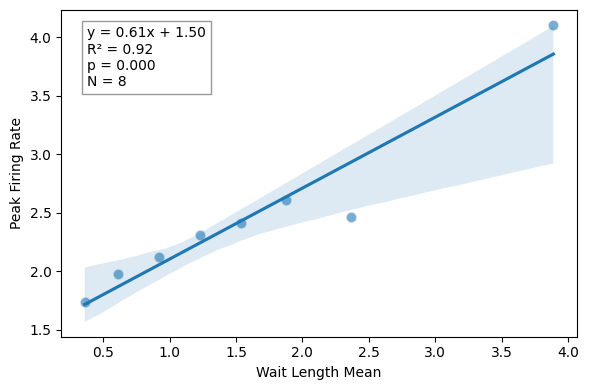

In [35]:
# Fit the regression model
X = sm.add_constant(ten_quantile_df['wait_length_mean'])
y = ten_quantile_df['peak_fr']
model = sm.OLS(y, X).fit()

# Create plot
plt.figure(figsize=(6, 4))
ax = sns.regplot(
    data=ten_quantile_df,
    x="wait_length_mean",
    y='peak_fr',
    scatter_kws={'s': 60, 'alpha': 0.6, 'edgecolor': 'w'},
)

# Add regression statistics to plot
stats_text = (
    f"y = {model.params[1]:.2f}x + {model.params[0]:.2f}\n"
    f"R² = {model.rsquared:.2f}\n"
    f"p = {model.pvalues[1]:.3f}\n"
    f"N = {len(ten_quantile_df)}"
)

ax.text(
    0.05, 0.95, 
    stats_text,
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.xlabel("Wait Length Mean")
plt.ylabel("Peak Firing Rate")
# plt.title(unit_name)
plt.tight_layout()
# plt.savefig(os.path.join(figure_dir, f"{unit_name}.png"), dpi=300, bbox_inches='tight')
# plt.close()  # Close the figure to free memory

didnt work below

In [ ]:
trials_histo, spikes_histo = prepare_data_for_histogram_by_quantile(
            trials, spikes, anchor, k.ANCHORED_PERIODS, sorter
            )

In [ ]:
spikes_histo

In [ ]:
trials_by_trial = trials_histo.groupby('trial_id')
spikes_by_trial = spikes_histo.groupby('trial_id')

In [ ]:
trial_data_list = []
for idx, trial_spikes in spikes_by_trial:
    trial_trial = trials_by_trial.get_group(idx)
    bin_centers, fr, _ = calculate_firing_rates(
            trial_trial, trial_spikes, anchor, time_step, trial_count_mask, sigma)
    trial_data_dict = {
        'trial_id': idx,
        'peak_fr': fr.max(),
        'peak_time': bin_centers[np.argmax(fr)]
    }
    trial_data_list.append(trial_data_dict)
trial_data_df = pd.DataFrame(trial_data_list)

In [ ]:
trial_data_df['peak_fr'].nunique()

In [ ]:
bin_centers, fr, _ = calculate_firing_rates(
            trial_trial, trial_spikes, anchor, time_step, trial_count_mask, sigma, session_fr
        )
plt.plot(bin_centers, fr)

In [ ]:
trial_data_df_with_wait_length = pd.merge(trial_data_df, trials_histo, on='trial_id')

In [ ]:
to_plot = trial_data_df_with_wait_length.loc[trial_data_df_with_wait_length['peak_time'].between(-1, 0)].copy()
final_to_plot = trial_data_df_with_wait_length.loc[trial_data_df_with_wait_length['wait_length']<10]

In [ ]:
final_to_plot

In [ ]:
final_to_plot.peak_fr.nunique()

In [ ]:
sns.scatterplot(data=final_to_plot, x='wait_length', y='peak_fr')

In [ ]:
# Plot with regression line and 95% confidence interval
sns.lmplot(data=final_to_plot, x='wait_length', y='peak_fr',height=6, aspect=1.5)

# Customize plot
plt.title('Linear Regression Fit')
plt.xlabel('X Variable')
plt.ylabel('Y Variable')
plt.grid(True)
plt.show()

In [ ]:
display(trial_trial)

In [ ]:
trial_trial = trials_by_trial.get_group(248)
trial_spikes = spikes_by_trial.get_group(248)

In [ ]:

bin_centers, fr, _ = calculate_firing_rates(
            trial_trial, trial_spikes, anchor, time_step, trial_count_mask, sigma, session_fr
        )
peak_fr = fr.max()
peak_time = bin_centers[np.argmax(fr)]

In [ ]:
peak_time

In [ ]:
peak_fr

In [ ]:
bin_centers

In [ ]:
mean_fr

In [ ]:
bounds = (
        np.round(trials_histo.aligned_start_time.min(), decimals=1),
        np.round(trials_histo.aligned_end_time.max(), decimals=1)
    )

In [ ]:
bounds

In [ ]:
def generate_time_frame(trials, time_step, trial_count_mask=1):
    """
    Generate time bins and active trial counts.
    """
    # Calculate bounds (with protection against empty data)
    if len(trials) == 0:
        return np.array([]), np.array([]), np.array([])
        
    bounds = (
        np.round(trials.aligned_start_time.min(), decimals=1),
        np.round(trials.aligned_end_time.max(), decimals=1)
    )
    
    # Create bins
    bin_edges = np.arange(
        bounds[0] - time_step,
        bounds[1] + 2*time_step,
        time_step
    )
    bin_centers = bin_edges[:-1] + time_step/2
    
    # Calculate active trials
    active_trials = np.zeros(len(bin_edges) - 1, dtype=int)
    for _, trial in trials.iterrows():
        occupied = (bin_edges[:-1] < trial['aligned_end_time']) & \
                  (bin_edges[1:] > trial['aligned_start_time'])
        active_trials[occupied] += 1

    # Apply mask with safety checks
    if trial_count_mask > 0:
        valid_mask = active_trials >= trial_count_mask
        if not np.any(valid_mask):  # No valid bins
            return np.array([]), np.array([]), np.array([])
            
        bin_edges = np.append(
            bin_edges[:-1][valid_mask],
            bin_edges[:-1][valid_mask][-1] + time_step
        )
        bin_centers = bin_centers[valid_mask]
        active_trials = active_trials[valid_mask]
        
    return bin_edges, bin_centers, active_trials

def calculate_firing_rates(trials, spikes, anchor, time_step, trial_count_mask, sigma=None, normalize_by=None):
    bin_edges, bin_centers, active_trials = generate_time_frame(trials, time_step, trial_count_mask)
    
    # Handle case where no bins meet criteria
    if len(bin_edges) == 0:
        return np.array([]), np.array([]), np.array([])

    # Bin spikes for each trial, shape is [trial, bin]
    counts = np.array([
        np.histogram(trial[anchor], bins=bin_edges)[0]
        for _, trial in spikes.groupby('trial_id')
    ])
    rates = counts / time_step

    mean_fr = np.nansum(rates, axis=0) / active_trials
    sem_fr = np.std(rates, axis=0) / np.sqrt(active_trials)

    if sigma > 0:
        mean_fr = gaussian_filter1d(mean_fr, sigma=sigma)
        sem_fr = gaussian_filter1d(sem_fr, sigma=sigma)

    if normalize_by:
        mean_fr = mean_fr/normalize_by
        sem_fr = sem_fr/normalize_by

    return bin_centers, mean_fr, sem_fr